# Module 6

## Video 29: Working with Aggregated Cargo Movements Data
**Python for the Energy Industry**

In this lesson, we will be working with the data from the previous lesson. We will practice visualising this data. 

[Cargo Movements documentation](https://vortechsa.github.io/python-sdk/endpoints/cargo_movements/)

To start we follow the steps to get our Cargo Movements DataFrame:

In [3]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

In [4]:
# Find US ID
us = [g.id for g in v.Geographies().search('united states').to_list() if 'country' in g.layer]
assert len(us) == 1

# Find crude ID
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

# Columns to pull out, and shortened names
required_columns = ["vessels.0.name","vessels.0.vessel_class","product.group.label","product.category.label","quantity",
    "status","events.cargo_port_load_event.0.location.port.label","events.cargo_port_load_event.0.end_timestamp",
    "events.cargo_port_unload_event.0.location.port.label","events.cargo_port_unload_event.0.location.country.label",
    "events.cargo_port_unload_event.0.end_timestamp"]

new_labels = ["vessel_name","vessel_class","product_group","product_category","quantity","status",
    "loading_port","loading_finish","unloading_port","unloading_country","unloading_finish"]

relabel = dict(zip(required_columns,new_labels))

cms = v.CargoMovements().search(
        filter_activity = 'loading_end',
        filter_origins = us,
        exclude_destinations = us,
        filter_products = crude,
        filter_time_min = seven_weeks_ago,
        filter_time_max = now,
        cm_unit = 'b'
    ).to_df(columns=required_columns).rename(relabel,axis=1)

cms['loading_week'] = cms['loading_finish'].dt.isocalendar().week

Let's start by making a bar chart of weekly exports:

Text(0, 0.5, 'US exports (bbl)')

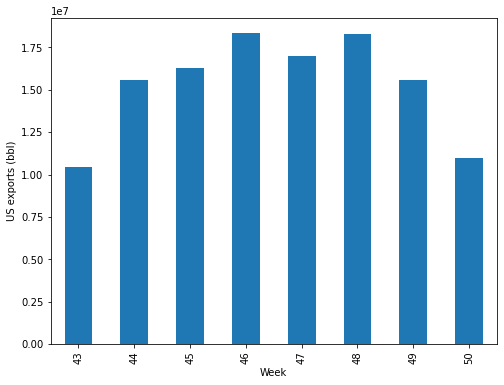

In [5]:
weekly_quantity = cms.groupby('loading_week').sum()

ax = weekly_quantity.plot.bar(y='quantity',legend=False,figsize=(8,6))
ax.set_xlabel('Week')
ax.set_ylabel('US exports (bbl)')

By assigning the plot to the variable `ax` we can make some further tweaks, like setting the x and y axis labels.

What if we wanted to represent the breakdown by product category? These can be plotted with bars side-by-side:

Text(0, 0.5, 'US exports (bbl)')

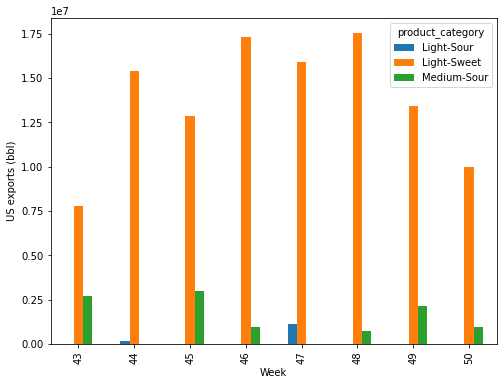

In [6]:
quantity_by_category = cms.groupby(by = ['loading_week','product_category']).sum().reset_index()
quantity_by_category = quantity_by_category.pivot(index = 'loading_week',columns = 'product_category',values = 'quantity')
quantity_by_category = quantity_by_category.fillna(0)

ax = quantity_by_category.plot.bar(figsize=(8,6))
ax.set_xlabel('Week')
ax.set_ylabel('US exports (bbl)')

As there are many products with zero exports, this leaves a lot of holes in the plot. A better way to represent this is 'stacked':

Text(0, 0.5, 'US exports (bbl)')

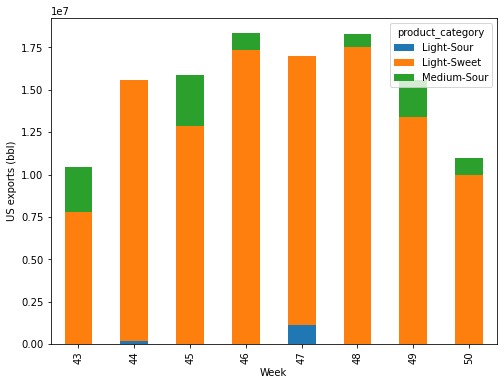

In [7]:
ax = quantity_by_category.plot.bar(stacked=True,figsize=(8,6))
ax.set_xlabel('Week')
ax.set_ylabel('US exports (bbl)')

What about visualising the share of exports to destination countries? A pie chart would be suitable for this.

<AxesSubplot:ylabel='%'>

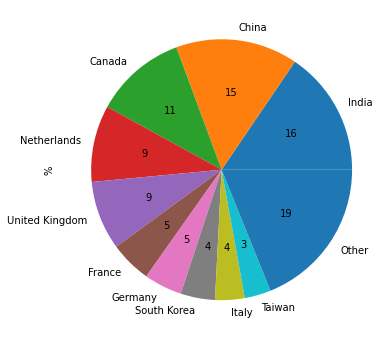

In [11]:
quantity_by_destination = cms.groupby('unloading_country').sum()[['quantity']]
quantity_by_destination.sort_values(by='quantity',ascending = False, inplace=True)

top_destination_countries = quantity_by_destination.head(10)
rest = pd.DataFrame(index = ['Other'], columns = ['quantity'])
rest.loc['Other'] = quantity_by_destination[10:].sum().values
top_destination_countries = pd.concat([top_destination_countries, rest])
top_destination_countries['%'] = round(top_destination_countries['quantity']*100 / top_destination_countries['quantity'].sum(),2)

top_destination_countries.plot.pie(y='%',figsize=(6,6),legend=False,autopct='%.0f')

Another type of plot we can make is the histogram, which shows the distribution of values in a column. Here's the distribution of quantity:

<AxesSubplot:ylabel='Frequency'>

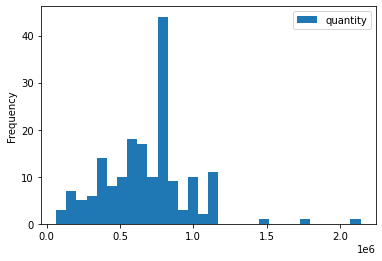

In [12]:
cms.plot.hist(y='quantity',bins=30)

Do we think this distribution is different for different products? We can test by pivoting.

<AxesSubplot:ylabel='Frequency'>

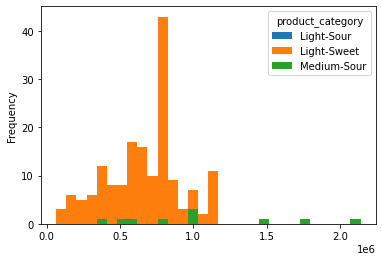

In [14]:
cms_product = cms.pivot(columns = 'product_category',values = 'quantity')[['Light-Sour','Light-Sweet','Medium-Sour']]
cms_product.plot.hist(bins=30)

### Exercise

Instead of US crude exports, pick a different dataset to examine. Say, Saudi Arabian exports, or Chinese imports. Follow the steps of the last 2 lessons to aggregate and visualise different aspects of this data.